<center><h1>Exploratory Data Analysis</h1></center>

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
##Import any other packages you may need here

pd.set_option('display.max_columns', None)# Display all the columns
pd.set_option('display.max_rows', None)# Display all the rows

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
data_df = pd.read_csv('/data/Data_Entry_2017.csv')
data_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [3]:
# Drop Unnamed: 11

data_df = data_df.drop('Unnamed: 11', axis=1)

In [4]:
# Count the number of images / rows

len(data_df['Image Index'].unique())

112120

In [5]:
# Count the number of patients

len(data_df['Patient ID'].unique())

30805

In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 9.4+ MB


## Understand the Distribution
To understand distributions of variables as they relate to pneumonia, let's try splitting up the 'Finding Labels' column into one additional column per disease and put a binary flag in that column to indicate the presence of the disease

In [7]:
# Create all_labels which consist of the diseases present in the dataset

all_labels = np.unique(list(chain(*data_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

# Verify all_labels
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

# Create column per disease and put a binary flag
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data_df[c_label] = data_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

data_df.head(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### How are the different diseases distributed in the dataset in terms of frequency and co-occurrence with pneumonia? 

Let's check the values of 'Patient Age' first.

In [8]:
sorted(data_df['Patient Age'].unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 411,
 412,
 413,
 414]

From the above result, we see that some of the values of 'Patient Age' doesn't looks right. After age 95, sudently the values jumps from 148 to 414. Since age 148 and above doesn't make any sense, we will ignore this subset of the dataset. We will call the new dataset without this subset **data_df2**.

In [9]:
data_df2 = data_df[(data_df['Patient Age'] <= 95)]
len(data_df2)

112104

In [10]:
# Count the number of patients in data_df2

len(data_df2['Patient ID'].unique())

30802

We see that we have croped only 16 rows and 3 patients from data_df.

Now let's see the proportion of diseases in data_df2.

In [11]:
# Check the proportion of shown diseases in images

data_df2[all_labels].sum()/len(data_df2)

Atelectasis           0.103101
Cardiomegaly          0.024763
Consolidation         0.041631
Edema                 0.020535
Effusion              0.118783
Emphysema             0.022443
Fibrosis              0.015040
Hernia                0.002025
Infiltration          0.177433
Mass                  0.051550
No Finding            0.538366
Nodule                0.056474
Pleural_Thickening    0.030186
Pneumonia             0.012756
Pneumothorax          0.047286
dtype: float64

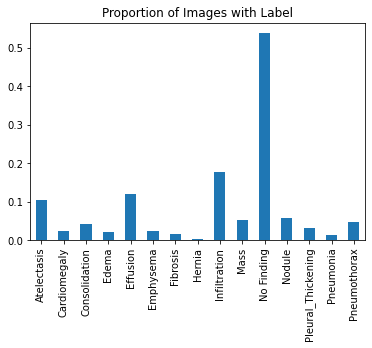

In [12]:
ax = (data_df2[all_labels].sum()/len(data_df2)).plot(kind='bar')
ax.set(title = 'Proportion of Images with Label')

plt.show()

Above, we see the relative frequencies of each disease in the dataset. It looks like 'No Finding' is the most common occurrence. 'No Finding' can never appear with any other label by definition, so we know that in 53.8% of this dataset, there is no finding in the image. As for pneumonia, it's only appears in 1.3% of this dataset.

Let's see how frequently 'Pneumonia' appears with all of the other diseases: 

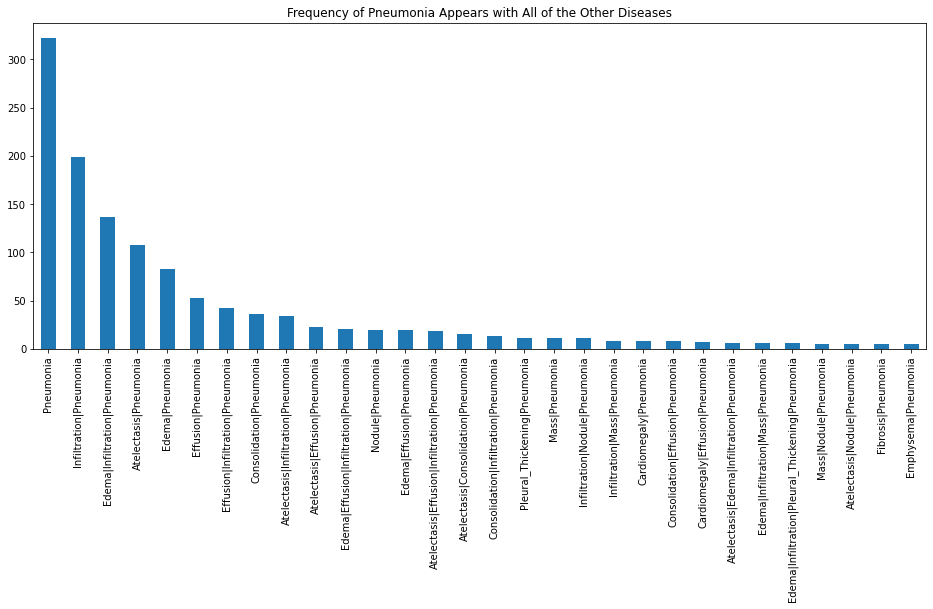

In [13]:
plt.figure(figsize=(16,6))
data_df2[data_df2.Pneumonia ==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')
plt.title('Frequency of Pneumonia Appears with All of the Other Diseases')
plt.show()

In [14]:
# Let's see the exact proportion of comorbidities among pnuemonia

data_df2[data_df2.Pneumonia ==1]['Finding Labels'].value_counts()/len(data_df2[data_df2.Pneumonia ==1])

Pneumonia                                                                                         0.225175
Infiltration|Pneumonia                                                                            0.139161
Edema|Infiltration|Pneumonia                                                                      0.095804
Atelectasis|Pneumonia                                                                             0.075524
Edema|Pneumonia                                                                                   0.058042
Effusion|Pneumonia                                                                                0.037063
Effusion|Infiltration|Pneumonia                                                                   0.029371
Consolidation|Pneumonia                                                                           0.025175
Atelectasis|Infiltration|Pneumonia                                                                0.023776
Atelectasis|Effusion|Pneumonia       

It looks like Pneumonia actually occurs alone for the most part, and its most-common comorbidities are Infiltration, Edema and Infiltration, and Atelectasis . 

Now let's count the number of images which show 'Pneumonia' in the dataset.

In [15]:
len(data_df2[data_df2.Pneumonia ==1])

1430

### Now let's move on to looking at age & gender:

Since most of the information per patient is stored in several rows, we will do some basic grouping to get the patient age, patient gender, diseases, and sum of diseases per patient.

In [16]:
# Group the patient ID to see the age of each patient

group = data_df2[['Patient ID', 'Patient Age', 'Patient Gender']]
group1_df = group.groupby(['Patient ID'], as_index = False).mean()
group1_df.head(3)

,Patient ID,Patient Age
0,1,58.0
1,2,81.0
2,3,77.5


In [17]:
# Group the patient ID and Patient Gender 

group2_df = group.groupby(['Patient ID', 'Patient Gender'], as_index=False).count()

# Drop the Patient Age since it doesn't make sense to count them 
group2_df = group2_df.drop('Patient Age', axis=1)
group2_df.head(3)

,Patient ID,Patient Gender
0,1,M
1,2,M
2,3,F


We will count the number of disease from images taken for each patient. Here, if a patient has 'Disease A' in follow up 0, then 'No Finding' in follow up 1, and later 'Disease A, Disease B' in follow up 2, we will assume the patient has 'Disease A' and 'Disease B'. Therefore, the sum of diseases found in all images for that patient is 2.

In [18]:
# Let's count the number of disease per patient and create a dataframe called group3_df

group2=data_df2[['Patient ID', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 
                 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 
                 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']]

group3_df = group2.groupby(['Patient ID'], as_index=False).sum()

# if the sum of a particular disease > 1, then we consider that patient has one that particular disease
for index, row in group3_df.iterrows():
    for i in all_labels:
        if row[i] > 1:
            group3_df = group3_df.replace(row[i], 1)

# Remove 'No Finding' column since it is not a disease
group3_df = group3_df.drop('No Finding', axis=1)

# Sum the diseases
group3_df['Sum_of_Diseases'] = group3_df[['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 
                 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 
                 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']].sum(axis=1)
group3_df.head(3)

,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Sum_of_Diseases
0,1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0


In [19]:
# Combine group1_df with group 3_df to create group4_df
group4_df = pd.merge(group1_df, group3_df, how='left')

# Combine group2_df with group 4_df to create group4_df
group4_df = pd.merge(group2_df, group4_df, how='left')

group4_df.head(3)

,Patient ID,Patient Gender,Patient Age,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Sum_of_Diseases
0,1,M,58.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,2,M,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,F,77.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0


In [20]:
sum(group4_df.Pneumonia)

1008.0

There are 1008 patients with pneumonia out of 30802 patients. 

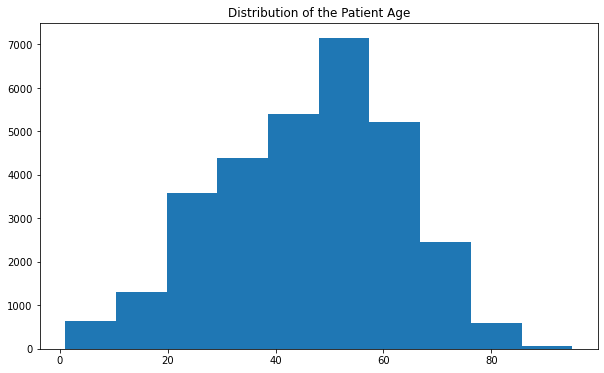

In [21]:
# Below is the histogram of all patient ages (out of 30802 patients)

plt.figure(figsize=(10,6))
plt.hist(group4_df['Patient Age'])
plt.title('Distribution of the Patient Age')
plt.show()

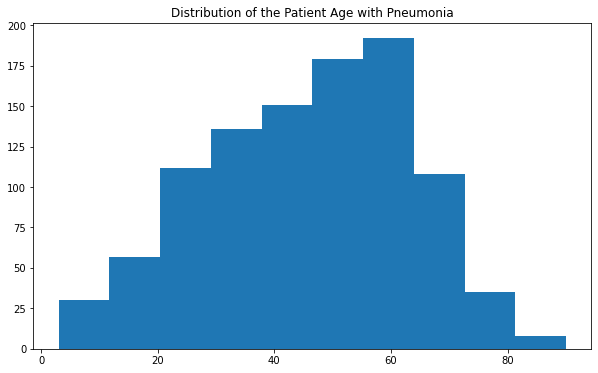

In [22]:
# Below is the histogram of all patient ages with pneumonia (out of 1008 patients)

plt.figure(figsize=(10,6))
plt.hist(group4_df[group4_df.Pneumonia==1]['Patient Age'])
plt.title('Distribution of the Patient Age with Pneumonia')
plt.show()

In [23]:
print("Minimum age with Pneumonida: ",group4_df[group4_df.Pneumonia==1]['Patient Age'].min())

Minimum age with Pneumonida:  3.0


In [24]:
print("Maximum age with Pneumonida: ",group4_df[group4_df.Pneumonia==1]['Patient Age'].max())

Maximum age with Pneumonida:  90.0


Looks like the distribution of age across the whole population is slightly different than it is with Pneumonia. The distribution of the whole population spans the age range but has a large peak around 50. On the other hand, the distribution of the patients with Pneumonia seems to be heavier from age 3 to 65. 

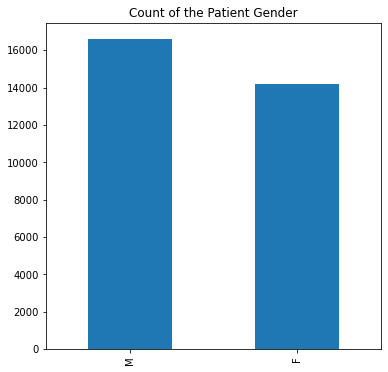

In [25]:
# Below is the histogram of all patient gender (out of 30802 patients)

plt.figure(figsize=(6,6))
group4_df['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Count of the Patient Gender')
plt.show()

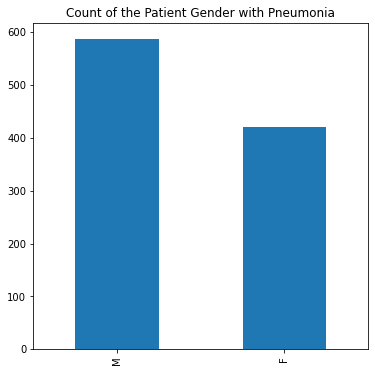

In [26]:
# Below is the histogram of all patient gender with pneumonia (out of 1008 patients)

plt.figure(figsize=(6,6))
group4_df[group4_df.Pneumonia ==1]['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Count of the Patient Gender with Pneumonia')
plt.show()

Gender distribution seems to be pretty equal in the whole population as well as with Pneumonia, with a slight preference towards males in the Pneumonia distribution

### Explore the view position in the dataset

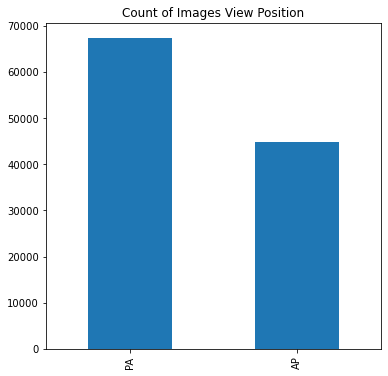

In [27]:
plt.figure(figsize=(6,6))
data_df2['View Position'].value_counts().plot(kind='bar')
plt.title('Count of Images View Position')
plt.show()

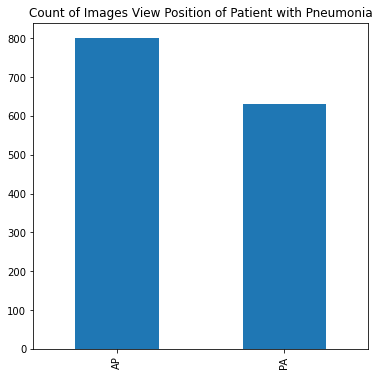

In [28]:
plt.figure(figsize=(6,6))
data_df2[data_df2.Pneumonia ==1]['View Position'].value_counts().plot(kind='bar')
plt.title('Count of Images View Position of Patient with Pneumonia')
plt.show()

The distribution of View Position of the whole images in the dataset is different from the distribution of the patient with Pneumonia with the slight preference toward AP for the patient with Pneumonia.

### How age & gender relate to the the number of disease found in the images of each patient?

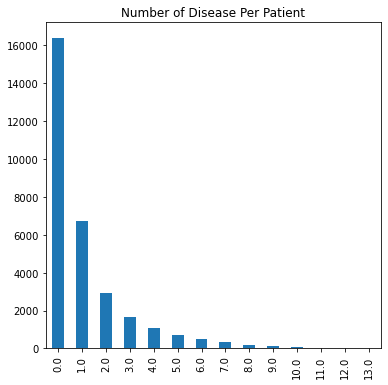

In [29]:
# Let's see the number of disease per patient

plt.figure(figsize=(6,6))
group4_df['Sum_of_Diseases'].value_counts().plot(kind='bar')
plt.title('Number of Disease Per Patient')
plt.show()

In [30]:
# Calculate the proportion of the number of disease per patient

group4_df['Sum_of_Diseases'].value_counts()/len(group4_df)

0.0     0.532465
1.0     0.218882
2.0     0.094409
3.0     0.053146
4.0     0.035290
5.0     0.023018
6.0     0.016752
7.0     0.010876
8.0     0.006655
9.0     0.004513
10.0    0.002727
11.0    0.000909
12.0    0.000227
13.0    0.000130
Name: Sum_of_Diseases, dtype: float64

We can see the majority or 53.2% of patients have no disease. Followed by 21.9% of patients have one disease and 9.5% of patients have two diseases.

In [31]:
from scipy import stats

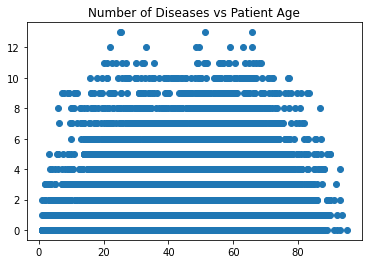

In [32]:
# Check if number of disease increases as age increases

plt.scatter(group4_df['Patient Age'],group4_df['Sum_of_Diseases'])
plt.title('Number of Diseases vs Patient Age')
plt.show()

In [33]:
pearson_coef, p_value = stats.pearsonr(group4_df['Sum_of_Diseases'], group4_df['Patient Age'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.1190106171064734  with a P-value of P = 1.500645289788779e-97


The above result shows that there is barely any linear relationship between age and the number of disease (0.1190) 

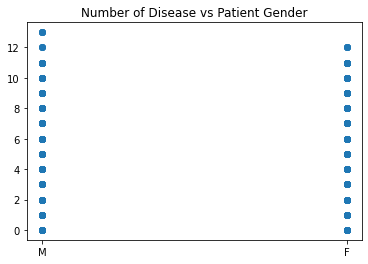

In [34]:
# Check if number of diseases relate to gender

plt.scatter(group4_df['Patient Gender'],group4_df['Sum_of_Diseases'])
plt.title('Number of Disease vs Patient Gender')
plt.show()

In [35]:
# Calculate the mean of Sum_of_Diseases per gender

gender_group = group4_df[["Patient Gender", "Sum_of_Diseases"]].groupby(["Patient Gender"], as_index=False).mean()
gender_group

,Patient Gender,Sum_of_Diseases
0,F,1.082975
1,M,1.180408


In [36]:
# Let's see if the differences of mean of sum_of_diseases between gender is statistically significant.

stats.ttest_ind(group4_df[group4_df['Patient Gender'] == 'M']['Sum_of_Diseases'], 
                group4_df[group4_df['Patient Gender'] == 'F']['Sum_of_Diseases'])

Ttest_indResult(statistic=4.700119502928666, pvalue=2.6113283448516923e-06)

The above tells us that there is no statistically significant difference in the mean of number of disease between gender. 

## Pixel-level assessments of the imaging data for healthy & pneumonia. 

### Data Preparation.

In [37]:
from skimage import io
import random

In [38]:
### Load 'sample_labels.csv' data for pixel level assessments

sample_df = pd.read_csv('sample_labels.csv')

# Create a list of image path

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', sample_df.shape[0])

# Add a column called 'path' into sample_df and insert all_image_path

sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.head(3)

Scans found: 112120 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00000017_001.png


In [39]:
# Let's check the age of the patient like we did in data_df

sorted(sample_df['Patient Age'].unique())

['001D',
 '002Y',
 '003Y',
 '004Y',
 '005Y',
 '006Y',
 '007Y',
 '008Y',
 '009Y',
 '010Y',
 '011Y',
 '012Y',
 '013M',
 '013Y',
 '014Y',
 '015Y',
 '016Y',
 '017Y',
 '018Y',
 '019Y',
 '020Y',
 '021Y',
 '022Y',
 '023Y',
 '024Y',
 '025Y',
 '026Y',
 '027Y',
 '028Y',
 '029Y',
 '030Y',
 '031Y',
 '032Y',
 '033Y',
 '034Y',
 '035Y',
 '036Y',
 '037Y',
 '038Y',
 '039Y',
 '040Y',
 '041Y',
 '042Y',
 '043Y',
 '044Y',
 '045Y',
 '046Y',
 '047Y',
 '048Y',
 '049Y',
 '050Y',
 '051Y',
 '052Y',
 '053Y',
 '054Y',
 '055Y',
 '056Y',
 '057Y',
 '058Y',
 '059Y',
 '060Y',
 '061Y',
 '062Y',
 '063Y',
 '064Y',
 '065Y',
 '066Y',
 '067Y',
 '068Y',
 '069Y',
 '070Y',
 '071Y',
 '072Y',
 '073Y',
 '074Y',
 '075Y',
 '076Y',
 '077Y',
 '078Y',
 '079Y',
 '080Y',
 '081Y',
 '082Y',
 '083Y',
 '084Y',
 '085Y',
 '086Y',
 '087Y',
 '088Y',
 '089Y',
 '094Y',
 '411Y']

In [40]:
# Make sure the patient age '001D' means 1 year old. Below we try to get the Patient ID to be
# traced back to the information in data_df

sample_df[sample_df['Patient Age']=='001D']

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
4749,00024680_000.png,No Finding,0,24680,001D,M,PA,2734,2991,0.143,0.143,/data/images_010/images/00024680_000.png


In [41]:
# Trace back the above Patient ID to data_df. It shows 001D means 1 year old 

data_df[data_df['Patient ID']==24680]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
94960,00024680_000.png,No Finding,0,24680,1,M,PA,2734,2991,0.143,0.143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [42]:
# Now let's drop the patient whose age is 411

sample_df = sample_df[(sample_df['Patient Age'] < '095Y')]
len(sample_df)

5605

In [43]:
# Count the number of patients

len(sample_df['Patient ID'].unique())

4229

In [44]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5605 entries, 0 to 5605
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5605 non-null   object 
 1   Finding Labels               5605 non-null   object 
 2   Follow-up #                  5605 non-null   int64  
 3   Patient ID                   5605 non-null   int64  
 4   Patient Age                  5605 non-null   object 
 5   Patient Gender               5605 non-null   object 
 6   View Position                5605 non-null   object 
 7   OriginalImageWidth           5605 non-null   int64  
 8   OriginalImageHeight          5605 non-null   int64  
 9   OriginalImagePixelSpacing_x  5605 non-null   float64
 10  OriginalImagePixelSpacing_y  5605 non-null   float64
 11  path                         5605 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 569.3+ KB


Similar to the data_df, to understand distributions of variables as they relate to pneumonia, let's try splitting up the 'Finding Labels' column into one additional column per disease and put a binary flag in that column to indicate the presence of the disease

In [45]:
# Create all_labels which consist of the diseases present in the dataset

all_labels2 = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels2 = [x for x in all_labels if len(x)>0]

# Verify all_labels
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

# Create column per disease and put a binary flag
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

sample_df.head(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000013_005.png,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00000013_026.png,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00000017_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Explore the intensity values of images with No Pneumonia and Pneumonia.

In [46]:
# Let's plot few images from sample_df which images show Pneumonia or No Finding.

pneumonia_sample = sample_df[sample_df['Pneumonia'] == 1].sample(2, random_state=2)
normal_sample = sample_df[sample_df['Pneumonia'] == 0].sample(2, random_state=2)
sample2_df = pd.concat([pneumonia_sample, normal_sample])

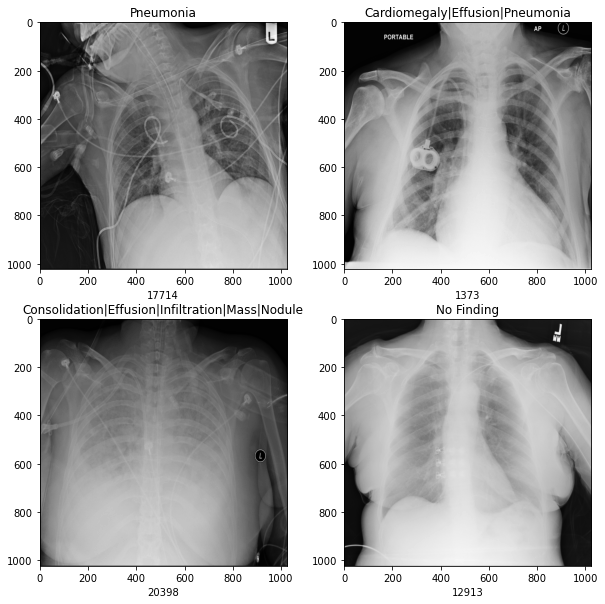

In [47]:
# Visualize some images from sample2_df

fig, m_axs = plt.subplots(2,2, figsize = (10, 10))
m_axs = m_axs.flatten()
imgs = sample2_df['path']
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(sample2_df.iloc[ind]['Finding Labels'])
    ax.set_xlabel(sample2_df.iloc[ind]['Patient ID'])
    ind=ind+1

Create two new dataframes which consist of normal (no pneumonia) or pneumonia chest-X-rays.

In [48]:
pneumonia_df = sample_df[sample_df['Pneumonia'] == 1].reset_index(drop=True)
normal_df = sample_df[sample_df['Pneumonia'] == 0].reset_index(drop=True)

In [49]:
# Check the length of pneumonia_df and normal_df

print(len(pneumonia_df))
print(len(normal_df))

62
5543


Since there are a lot more normal chest-x-rays than the ones with pneumonia, we will randomly select 62 nomal chest-x-rays. By doing so, we will have equal number of normal and pneumonia chest-x-rays to analyze.

In [50]:
#  randomly select 62 nomal chest-x-rays from normal_df and called it normal2_df

normal2_df = normal_df.sample(n=62, random_state=2).reset_index(drop=True)
normal2_df.shape

(62, 27)

Let's plot the intensity values from pneumonia_df and normal2_df

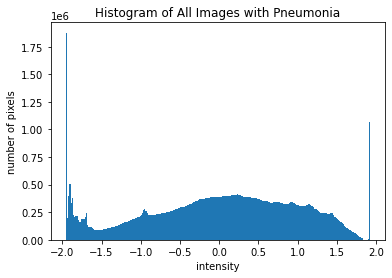

In [51]:
## Let's first get all of the intensity values of pneumonia_df
pneumonia_imgs = pneumonia_df['path']

pneumonia_intensities = []

for i in pneumonia_imgs: 
    
    img = io.imread(i)
    pneumonia_intensities.extend(img.ravel().tolist())

# Find the mean and standard deviation
mean_pn = np.mean(pneumonia_intensities)
std_pn = np.std(pneumonia_intensities)

# Standardize the plot
pneumonia_intensities_0 = (pneumonia_intensities-mean_pn)/std_pn    
    
plt.hist(pneumonia_intensities_0,bins=256)
plt.title('Histogram of All Images with Pneumonia')
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

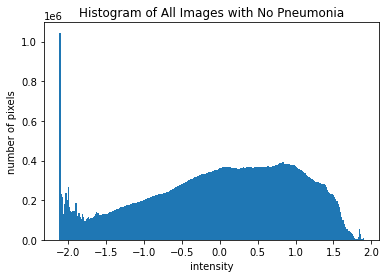

In [52]:
## Let's first get all of the intensity values from normal2_df
normal_imgs = normal2_df['path']

normal_intensities = []

for i in normal_imgs: 
    
    img = io.imread(i)
    normal_intensities.extend(img.ravel().tolist())

mean_nl = np.mean(normal_intensities)
std_nl = np.std(normal_intensities)

# Standardize the plot
normal_intensities_0 = (normal_intensities-mean_nl)/std_nl

plt.hist(normal_intensities_0,bins=256)

plt.title('Histogram of All Images with No Pneumonia')
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show()

The shape of the images looks the same. Both histograms have intensity values higher than the image mean at about one or two standard deviations. The intensity values of pneumonia images have two peaks on the left and right, while the intensity values of images with no pneumonia have a peak on the left because of the boders of the chest-x-rays. 

### Explore the pixel densities of each 14 disease labels present in the dataset.

In [53]:
# Create 'labels' which consist of all 14 disease labels
labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# test
labels[12]

'Pneumonia'

#### Atelectasis

In [54]:
atelectasis_df = sample_df[(sample_df[labels[0]] == 1) & (sample_df[labels[1]] == 0) & (sample_df[labels[2]] == 0)
                          & (sample_df[labels[3]] == 0)& (sample_df[labels[4]] == 0)& (sample_df[labels[5]] == 0)
                          & (sample_df[labels[6]] == 0)& (sample_df[labels[7]] == 0)& (sample_df[labels[8]] == 0)
                          & (sample_df[labels[9]] == 0)& (sample_df[labels[10]] == 0)& (sample_df[labels[11]] == 0)
                          & (sample_df[labels[12]] == 0)& (sample_df[labels[13]] == 0)]
# Take a sample
atelectasis_df.head(1)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,/data/images_001/images/00000030_001.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<function matplotlib.pyplot.show(*args, **kw)>

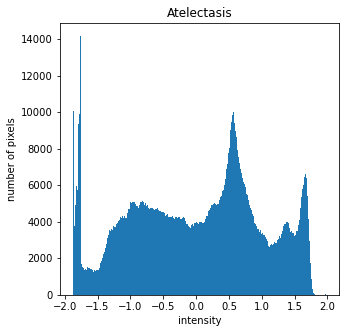

In [55]:
# Plot the histogram of Patient 30

img = io.imread(atelectasis_df['path'][3])

mean = np.mean(img)
std = np.std(img)

# Standardize the plot
atelectasis = (img-mean)/std

plt.figure(figsize=(5,5))
plt.hist(atelectasis.ravel(), bins = 256)
plt.title('Atelectasis')
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show

#### Cardiomegaly

In [56]:
cardiomegaly_df = sample_df[(sample_df[labels[0]] == 0) & (sample_df[labels[1]] == 1) & (sample_df[labels[2]] == 0)
                          & (sample_df[labels[3]] == 0)& (sample_df[labels[4]] == 0)& (sample_df[labels[5]] == 0)
                          & (sample_df[labels[6]] == 0)& (sample_df[labels[7]] == 0)& (sample_df[labels[8]] == 0)
                          & (sample_df[labels[9]] == 0)& (sample_df[labels[10]] == 0)& (sample_df[labels[11]] == 0)
                          & (sample_df[labels[12]] == 0)& (sample_df[labels[13]] == 0)]
# Take a sample
cardiomegaly_df.head(1)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
226,00001249_010.png,Cardiomegaly,10,1249,041Y,M,PA,2992,2991,0.143,0.143,/data/images_001/images/00001249_010.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<function matplotlib.pyplot.show(*args, **kw)>

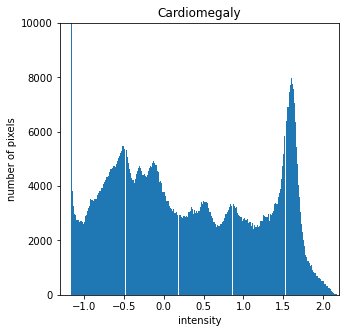

In [57]:
# Plot the histogram of Patient 1249

img = io.imread(cardiomegaly_df['path'][226])

mean = np.mean(img)
std = np.std(img)

# Standardize the plot
standard = (img-mean)/std

plt.figure(figsize=(5,5))
plt.hist(standard.ravel(), bins = 256)
plt.title('Cardiomegaly')
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.axis([-1.3, 2.2, 0, 10000])
plt.show

#### Consolidation

In [58]:
consolidation_df = sample_df[(sample_df[labels[0]] == 0) & (sample_df[labels[1]] == 0) & (sample_df[labels[2]] == 1)
                          & (sample_df[labels[3]] == 0)& (sample_df[labels[4]] == 0)& (sample_df[labels[5]] == 0)
                          & (sample_df[labels[6]] == 0)& (sample_df[labels[7]] == 0)& (sample_df[labels[8]] == 0)
                          & (sample_df[labels[9]] == 0)& (sample_df[labels[10]] == 0)& (sample_df[labels[11]] == 0)
                          & (sample_df[labels[12]] == 0)& (sample_df[labels[13]] == 0)]

# Take a sample
consolidation_df.head(1)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
20,00000116_019.png,Consolidation,19,116,075Y,F,AP,2500,2048,0.168,0.168,/data/images_001/images/00000116_019.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<function matplotlib.pyplot.show(*args, **kw)>

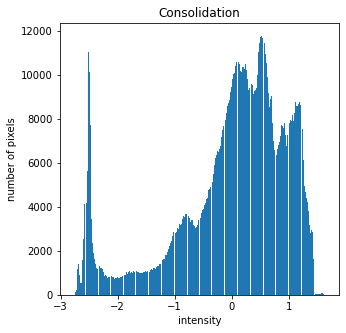

In [59]:
# Plot the histogram of Patient 116

img = io.imread(consolidation_df['path'][20])

mean = np.mean(img)
std = np.std(img)

# Standardize the plot
standard = (img-mean)/std

plt.figure(figsize=(5,5))
plt.hist(standard.ravel(), bins = 256)
plt.title('Consolidation')
plt.xlabel('intensity')
plt.ylabel('number of pixels')
#plt.axis([-1.3, 2.2, 0, 14000])
plt.show

#### Edema

In [60]:
edema_df = sample_df[(sample_df[labels[0]] == 0) & (sample_df[labels[1]] == 0) & (sample_df[labels[2]] == 0)
                          & (sample_df[labels[3]] == 1)& (sample_df[labels[4]] == 0)& (sample_df[labels[5]] == 0)
                          & (sample_df[labels[6]] == 0)& (sample_df[labels[7]] == 0)& (sample_df[labels[8]] == 0)
                          & (sample_df[labels[9]] == 0)& (sample_df[labels[10]] == 0)& (sample_df[labels[11]] == 0)
                          & (sample_df[labels[12]] == 0)& (sample_df[labels[13]] == 0)]

# Take a sample
edema_df.head(1)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
225,00001249_002.png,Edema,2,1249,040Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00001249_002.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<function matplotlib.pyplot.show(*args, **kw)>

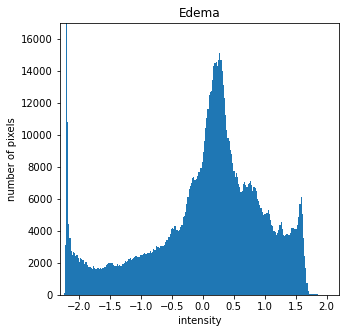

In [61]:
# Plot the histogram of Patient 1249

img = io.imread(edema_df['path'][225])

mean = np.mean(img)
std = np.std(img)

# Standardize the plot
standard = (img-mean)/std

plt.figure(figsize=(5,5))
plt.hist(standard.ravel(), bins = 256)
plt.title('Edema')
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.axis([-2.3, 2.2, 0, 17000])
plt.show

#### Effusion

In [62]:
effusion_df = sample_df[(sample_df[labels[0]] == 0) & (sample_df[labels[1]] == 0) & (sample_df[labels[2]] == 0)
                          & (sample_df[labels[3]] == 0)& (sample_df[labels[4]] == 1)& (sample_df[labels[5]] == 0)
                          & (sample_df[labels[6]] == 0)& (sample_df[labels[7]] == 0)& (sample_df[labels[8]] == 0)
                          & (sample_df[labels[9]] == 0)& (sample_df[labels[10]] == 0)& (sample_df[labels[11]] == 0)
                          & (sample_df[labels[12]] == 0)& (sample_df[labels[13]] == 0)]

# Take a sample
effusion_df.head(1)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143,/data/images_001/images/00000061_002.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<function matplotlib.pyplot.show(*args, **kw)>

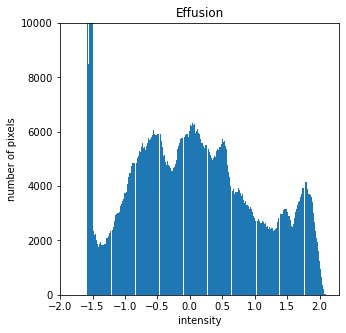

In [63]:
# Plot the histogram of Patient 61

img = io.imread(effusion_df['path'][8])

mean = np.mean(img)
std = np.std(img)

# Standardize the plot
standard = (img-mean)/std

plt.figure(figsize=(5,5))
plt.hist(standard.ravel(), bins = 256)
plt.title('Effusion')
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.axis([-2, 2.3, 0, 10000])
plt.show

#### Emphysema

In [64]:
emphysema_df = sample_df[(sample_df[labels[0]] == 0) & (sample_df[labels[1]] == 0) & (sample_df[labels[2]] == 0)
                          & (sample_df[labels[3]] == 0)& (sample_df[labels[4]] == 0)& (sample_df[labels[5]] == 1)
                          & (sample_df[labels[6]] == 0)& (sample_df[labels[7]] == 0)& (sample_df[labels[8]] == 0)
                          & (sample_df[labels[9]] == 0)& (sample_df[labels[10]] == 0)& (sample_df[labels[11]] == 0)
                          & (sample_df[labels[12]] == 0)& (sample_df[labels[13]] == 0)]

# Take a sample
emphysema_df.head(1)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
41,00000243_001.png,Emphysema,1,243,069Y,M,PA,2500,2048,0.168,0.168,/data/images_001/images/00000243_001.png,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<function matplotlib.pyplot.show(*args, **kw)>

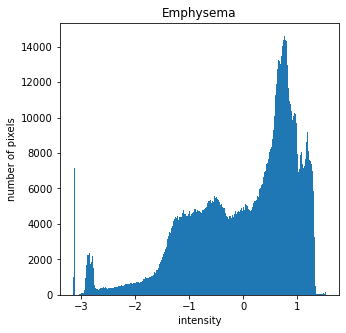

In [65]:
# Plot the histogram of Patient 243

img = io.imread(emphysema_df['path'][41])

mean = np.mean(img)
std = np.std(img)

# Standardize the plot
standard = (img-mean)/std

plt.figure(figsize=(5,5))
plt.hist(standard.ravel(), bins = 256)
plt.title('Emphysema')
plt.xlabel('intensity')
plt.ylabel('number of pixels')
#plt.axis([-2, 2.3, 0, 20000])
plt.show

#### Fibrosis

In [66]:
fibrosis_df = sample_df[(sample_df[labels[0]] == 0) & (sample_df[labels[1]] == 0) & (sample_df[labels[2]] == 0)
                          & (sample_df[labels[3]] == 0)& (sample_df[labels[4]] == 0)& (sample_df[labels[5]] == 0)
                          & (sample_df[labels[6]] == 1)& (sample_df[labels[7]] == 0)& (sample_df[labels[8]] == 0)
                          & (sample_df[labels[9]] == 0)& (sample_df[labels[10]] == 0)& (sample_df[labels[11]] == 0)
                          & (sample_df[labels[12]] == 0)& (sample_df[labels[13]] == 0)]

# Take a sample
fibrosis_df.head(1)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
31,00000181_001.png,Fibrosis,1,181,047Y,F,PA,2500,2048,0.171,0.171,/data/images_001/images/00000181_001.png,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<function matplotlib.pyplot.show(*args, **kw)>

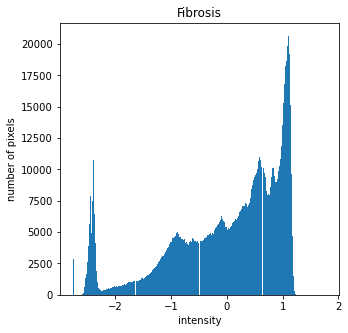

In [67]:
# Plot the histogram of Patient 181

img = io.imread(fibrosis_df['path'][31])

mean = np.mean(img)
std = np.std(img)

# Standardize the plot
standard = (img-mean)/std

plt.figure(figsize=(5,5))
plt.hist(standard.ravel(), bins = 256)
plt.title('Fibrosis')
plt.xlabel('intensity')
plt.ylabel('number of pixels')
#plt.axis([-2, 2.3, 0, 20000])
plt.show

#### Hernia

In [68]:
hernia_df = sample_df[(sample_df[labels[0]] == 0) & (sample_df[labels[1]] == 0) & (sample_df[labels[2]] == 0)
                          & (sample_df[labels[3]] == 0)& (sample_df[labels[4]] == 0)& (sample_df[labels[5]] == 0)
                          & (sample_df[labels[6]] == 0)& (sample_df[labels[7]] == 1)& (sample_df[labels[8]] == 0)
                          & (sample_df[labels[9]] == 0)& (sample_df[labels[10]] == 0)& (sample_df[labels[11]] == 0)
                          & (sample_df[labels[12]] == 0)& (sample_df[labels[13]] == 0)]

# Take a sample
hernia_df.head(1)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1418,00007352_000.png,Hernia,0,7352,056Y,M,PA,2500,2048,0.168,0.168,/data/images_004/images/00007352_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<function matplotlib.pyplot.show(*args, **kw)>

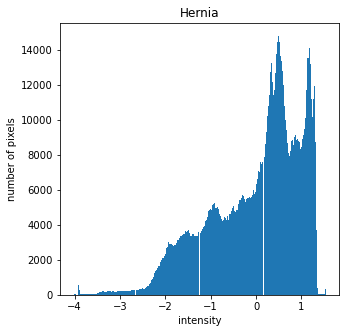

In [69]:
# Plot the histogram of Patient 7352

img = io.imread(hernia_df['path'][1418])

mean = np.mean(img)
std = np.std(img)

# Standardize the plot
standard = (img-mean)/std

plt.figure(figsize=(5,5))
plt.hist(standard.ravel(), bins = 256)
plt.title('Hernia')
plt.xlabel('intensity')
plt.ylabel('number of pixels')
#plt.axis([-2, 2.3, 0, 20000])
plt.show

#### Infiltration

In [70]:
infiltration_df = sample_df[(sample_df[labels[0]] == 0) & (sample_df[labels[1]] == 0) & (sample_df[labels[2]] == 0)
                          & (sample_df[labels[3]] == 0)& (sample_df[labels[4]] == 0)& (sample_df[labels[5]] == 0)
                          & (sample_df[labels[6]] == 0)& (sample_df[labels[7]] == 0)& (sample_df[labels[8]] == 1)
                          & (sample_df[labels[9]] == 0)& (sample_df[labels[10]] == 0)& (sample_df[labels[11]] == 0)
                          & (sample_df[labels[12]] == 0)& (sample_df[labels[13]] == 0)]

# Take a sample
infiltration_df.head(1)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
32,00000181_017.png,Infiltration,17,181,050Y,F,AP,2500,2048,0.168,0.168,/data/images_001/images/00000181_017.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


<function matplotlib.pyplot.show(*args, **kw)>

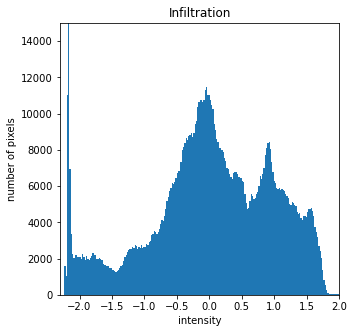

In [71]:
# Plot the histogram of Patient 131

img = io.imread(infiltration_df['path'][32])

mean = np.mean(img)
std = np.std(img)

# Standardize the plot
standard = (img-mean)/std

plt.figure(figsize=(5,5))
plt.hist(standard.ravel(), bins = 256)
plt.title('Infiltration')
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.axis([-2.3, 2, 0, 15000])
plt.show

#### Mass

In [72]:
mass_df = sample_df[(sample_df[labels[0]] == 0) & (sample_df[labels[1]] == 0) & (sample_df[labels[2]] == 0)
                          & (sample_df[labels[3]] == 0)& (sample_df[labels[4]] == 0)& (sample_df[labels[5]] == 0)
                          & (sample_df[labels[6]] == 0)& (sample_df[labels[7]] == 0)& (sample_df[labels[8]] == 0)
                          & (sample_df[labels[9]] == 1)& (sample_df[labels[10]] == 0)& (sample_df[labels[11]] == 0)
                          & (sample_df[labels[12]] == 0)& (sample_df[labels[13]] == 0)]

# Take a sample
mass_df.head(1)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
11,00000079_000.png,Mass,0,79,063Y,M,PA,2500,2048,0.168,0.168,/data/images_001/images/00000079_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


<function matplotlib.pyplot.show(*args, **kw)>

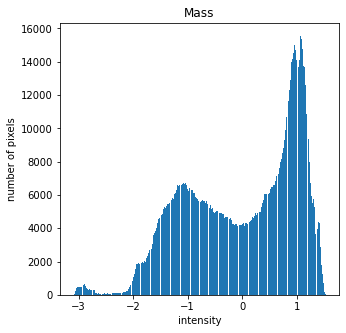

In [73]:
# Plot the histogram of Patient 79

img = io.imread(mass_df['path'][11])

mean = np.mean(img)
std = np.std(img)

# Standardize the plot
standard = (img-mean)/std

plt.figure(figsize=(5,5))
plt.hist(standard.ravel(), bins = 256)
plt.title('Mass')
plt.xlabel('intensity')
plt.ylabel('number of pixels')
#plt.axis([-2.3, 2.5, 0, 20000])
plt.show

#### Nodule

In [74]:
nodule_df = sample_df[(sample_df[labels[0]] == 0) & (sample_df[labels[1]] == 0) & (sample_df[labels[2]] == 0)
                          & (sample_df[labels[3]] == 0)& (sample_df[labels[4]] == 0)& (sample_df[labels[5]] == 0)
                          & (sample_df[labels[6]] == 0)& (sample_df[labels[7]] == 0)& (sample_df[labels[8]] == 0)
                          & (sample_df[labels[9]] == 0)& (sample_df[labels[10]] == 1)& (sample_df[labels[11]] == 0)
                          & (sample_df[labels[12]] == 0)& (sample_df[labels[13]] == 0)]

# Take a sample
nodule_df.head(1)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
100,00000556_000.png,Nodule,0,556,063Y,F,PA,2048,2500,0.168,0.168,/data/images_001/images/00000556_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<function matplotlib.pyplot.show(*args, **kw)>

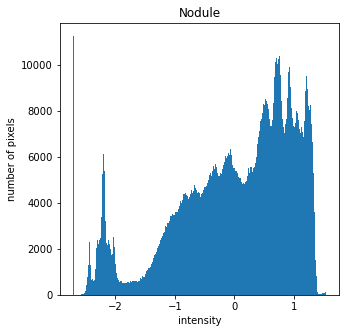

In [75]:
# Plot the histogram of Patient 556

img = io.imread(nodule_df['path'][100])

mean = np.mean(img)
std = np.std(img)

# Standardize the plot
standard = (img-mean)/std

plt.figure(figsize=(5,5))
plt.hist(standard.ravel(), bins = 256)
plt.title('Nodule')
plt.xlabel('intensity')
plt.ylabel('number of pixels')
#plt.axis([-2.3, 2.5, 0, 20000])
plt.show

#### Pleural Thickening

In [76]:
pleural_df = sample_df[(sample_df[labels[0]] == 0) & (sample_df[labels[1]] == 0) & (sample_df[labels[2]] == 0)
                          & (sample_df[labels[3]] == 0)& (sample_df[labels[4]] == 0)& (sample_df[labels[5]] == 0)
                          & (sample_df[labels[6]] == 0)& (sample_df[labels[7]] == 0)& (sample_df[labels[8]] == 0)
                          & (sample_df[labels[9]] == 0)& (sample_df[labels[10]] == 0)& (sample_df[labels[11]] == 1)
                          & (sample_df[labels[12]] == 0)& (sample_df[labels[13]] == 0)]

# Take a sample
pleural_df.head(1)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
120,00000649_000.png,Pleural_Thickening,0,649,058Y,M,PA,2500,2048,0.168,0.168,/data/images_001/images/00000649_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<function matplotlib.pyplot.show(*args, **kw)>

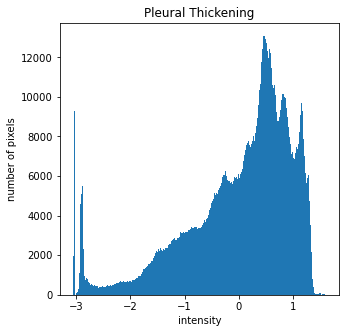

In [77]:
# Plot the histogram of Patient 649

img = io.imread(pleural_df['path'][120])

mean = np.mean(img)
std = np.std(img)

# Standardize the plot
standard = (img-mean)/std

plt.figure(figsize=(5,5))
plt.hist(standard.ravel(), bins = 256)
plt.title('Pleural Thickening')
plt.xlabel('intensity')
plt.ylabel('number of pixels')
#plt.axis([-2.3, 2.5, 0, 20000])
plt.show

#### Pneumonia

In [78]:
pneum_df = sample_df[(sample_df[labels[0]] == 0) & (sample_df[labels[1]] == 0) & (sample_df[labels[2]] == 0)
                          & (sample_df[labels[3]] == 0)& (sample_df[labels[4]] == 0)& (sample_df[labels[5]] == 0)
                          & (sample_df[labels[6]] == 0)& (sample_df[labels[7]] == 0)& (sample_df[labels[8]] == 0)
                          & (sample_df[labels[9]] == 0)& (sample_df[labels[10]] == 0)& (sample_df[labels[11]] == 0)
                          & (sample_df[labels[12]] == 1)& (sample_df[labels[13]] == 0)]

# Take a sample
pneum_df.head(1)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1631,00008470_008.png,Pneumonia,8,8470,030Y,F,AP,2500,2048,0.171,0.171,/data/images_004/images/00008470_008.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<function matplotlib.pyplot.show(*args, **kw)>

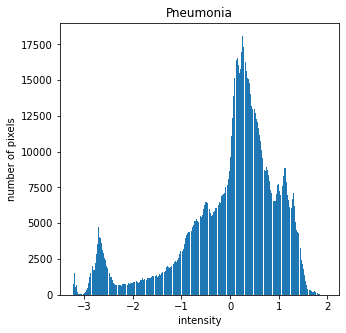

In [79]:
# Plot the histogram of Patient 8470

img = io.imread(pneum_df['path'][1631])

mean = np.mean(img)
std = np.std(img)

# Standardize the plot
standard = (img-mean)/std

plt.figure(figsize=(5,5))
plt.hist(standard.ravel(), bins = 256)
plt.title('Pneumonia')
plt.xlabel('intensity')
plt.ylabel('number of pixels')
#plt.axis([-2.3, 2.5, 0, 20000])
plt.show

#### Pneumothorax

In [80]:
pneumothorax_df = sample_df[(sample_df[labels[0]] == 0) & (sample_df[labels[1]] == 0) & (sample_df[labels[2]] == 0)
                          & (sample_df[labels[3]] == 0)& (sample_df[labels[4]] == 0)& (sample_df[labels[5]] == 0)
                          & (sample_df[labels[6]] == 0)& (sample_df[labels[7]] == 0)& (sample_df[labels[8]] == 0)
                          & (sample_df[labels[9]] == 0)& (sample_df[labels[10]] == 0)& (sample_df[labels[11]] == 0)
                          & (sample_df[labels[12]] == 0)& (sample_df[labels[13]] == 1)]

# Take a sample
pneumothorax_df.head(1)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
23,00000118_011.png,Pneumothorax,11,118,073Y,M,PA,2774,2991,0.143,0.143,/data/images_001/images/00000118_011.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<function matplotlib.pyplot.show(*args, **kw)>

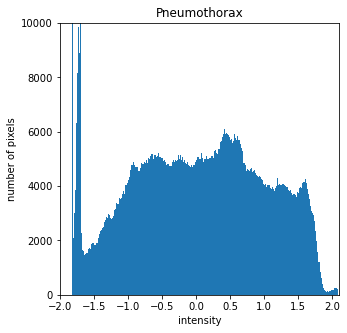

In [81]:
# Plot the histogram of Patient 118

img = io.imread(pneumothorax_df['path'][23])

mean = np.mean(img)
std = np.std(img)

# Standardize the plot
standard = (img-mean)/std

plt.figure(figsize=(5,5))
plt.hist(standard.ravel(), bins = 256)
plt.title('Pneumothorax')
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.axis([-2, 2.1, 0, 10000])
plt.show

From the plots of intensity values of each 14 desease labels, we see that Infiltration, Edema, and Pneumonia almost have similar distribution. All of them have the highest peak around the image mean. 

### Let's explore individual images which show pneumonia and no pneumonia (normal). 

We will take a closer look at these images using BBox_List_2017.csv from https://www.kaggle.com/nih-chest-xrays/data/version/3?select=BBox_List_2017.csv

In [82]:
box_df = pd.read_csv('BBox_List_2017.csv')
box_df.head(3)

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN


In [83]:
box_df.shape

(984, 9)

In [84]:
# We want to find rows of box_df which images are in pneumonia_df  

# Merge the pnemonia_df with box_df
pn_box = pd.merge(pneumonia_df, box_df, how='left')

# Remove the rows which 'Finding Label' is NaN
pn_box = pn_box[pn_box['Finding Label'].notna()]

pn_box

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
3,00003789_000.png,Nodule|Pneumonia,0,3789,041Y,M,AP,2500,2048,0.171,0.171,/data/images_002/images/00003789_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Pneumonia,272.497778,569.211267,100.124444,93.297778,NaN,NaN,NaN
22,00012834_113.png,Consolidation|Edema|Effusion|Pneumonia,113,12834,033Y,M,AP,2500,2048,0.168,0.168,/data/images_006/images/00012834_113.png,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,568.888889,260.063492,266.565079,423.686772,NaN,NaN,NaN
23,00013249_033.png,Cardiomegaly|Edema|Infiltration|Pneumonia,33,13249,015Y,M,AP,2500,2048,0.168,0.168,/data/images_006/images/00013249_033.png,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Cardiomegaly,415.017989,403.098413,467.030688,344.584127,NaN,NaN,NaN
24,00013249_033.png,Cardiomegaly|Edema|Infiltration|Pneumonia,33,13249,015Y,M,AP,2500,2048,0.168,0.168,/data/images_006/images/00013249_033.png,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,363.005291,418.268783,145.202116,279.568254,NaN,NaN,NaN
33,00016786_001.png,Infiltration|Pneumonia,1,16786,023Y,F,AP,3056,2544,0.139,0.139,/data/images_008/images/00016786_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Infiltrate,564.554497,199.382011,224.304762,490.869841,NaN,NaN,NaN
49,00021818_026.png,Consolidation|Pneumonia,26,21818,037Y,M,PA,2992,2991,0.143,0.143,/data/images_010/images/00021818_026.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,600.313228,297.989418,264.397884,297.989418,NaN,NaN,NaN
54,00023089_004.png,Infiltration|Pneumonia,4,23089,059Y,M,PA,2992,2991,0.143,0.143,/data/images_010/images/00023089_004.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,158.205291,521.210582,169.041270,124.613757,NaN,NaN,NaN


In [85]:
# We want to find rows of box_df which images are in normal_df  

# Merge the normal_df with box_df
nm_box = pd.merge(normal_df, box_df, how='left')

# Remove the rows which 'Finding Label' is NaN
nm_box = nm_box[nm_box['Finding Label'].notna()]

nm_box.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
211,00001153_004.png,Atelectasis,4,1153,064Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00001153_004.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atelectasis,307.029340,253.914080,97.848889,439.182222,NaN,NaN,NaN
255,00001373_009.png,Cardiomegaly,9,1373,058Y,M,AP,2500,2048,0.168,0.168,/data/images_002/images/00001373_009.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiomegaly,412.850794,468.114286,548.300529,501.705820,NaN,NaN,NaN
446,00002395_007.png,Effusion,7,2395,062Y,F,AP,2500,2048,0.168,0.168,/data/images_002/images/00002395_007.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Effusion,231.537778,448.606823,75.093333,158.151111,NaN,NaN,NaN


#### Exploration Pneumonia Images

Note that we will label the images and histograms using Patient ID.

In [86]:
# Sample 2 rows from pn_box

pn_box.sample(2, random_state=2)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
33,00016786_001.png,Infiltration|Pneumonia,1,16786,023Y,F,AP,3056,2544,0.139,0.139,/data/images_008/images/00016786_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Infiltrate,564.554497,199.382011,224.304762,490.869841,NaN,NaN,NaN
22,00012834_113.png,Consolidation|Edema|Effusion|Pneumonia,113,12834,033Y,M,AP,2500,2048,0.168,0.168,/data/images_006/images/00012834_113.png,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,568.888889,260.063492,266.565079,423.686772,NaN,NaN,NaN


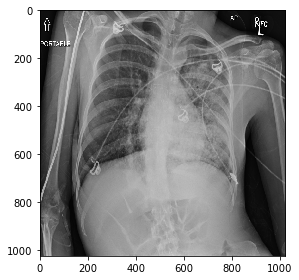

In [87]:
# Plot the image of Patient 16786

img1 = io.imread(pn_box['path'][33])
io.imshow(img1)

<function matplotlib.pyplot.show(*args, **kw)>

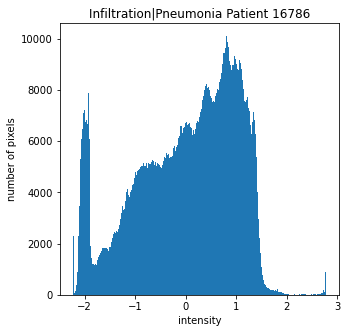

In [88]:
# Plot the histogram of Patient 16786

mean1 = np.mean(img1)
std1 = np.std(img1)

# Standardize the plot
pneumonia1 = (img1-mean1)/std1

plt.figure(figsize=(5,5))
plt.hist(pneumonia1.ravel(), bins = 256)
plt.title('Infiltration|Pneumonia Patient 16786')
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show

In [89]:
# Coordinate the bounding box of Patient 16786

lung1_x = [564,789]
lung1_y = [199,690]

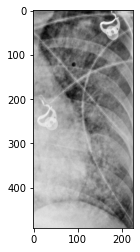

In [90]:
# Image from the bounding box of Patient 16786

plt.imshow(pneumonia1[lung1_y[0]:lung1_y[1],lung1_x[0]:lung1_x[1]],cmap='gray')

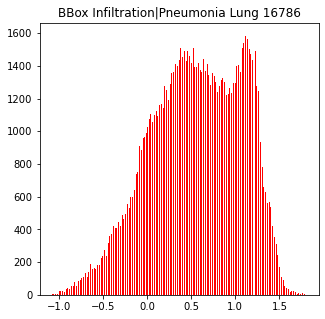

In [91]:
# Plot the histogram from the bounding box of Patient 16786

plt.figure(figsize=(5,5))
plt.hist(pneumonia1[lung1_y[0]:lung1_y[1],lung1_x[0]:lung1_x[1]].ravel(), bins = 256,color='red')
plt.title('BBox Infiltration|Pneumonia Lung 16786')
plt.show()

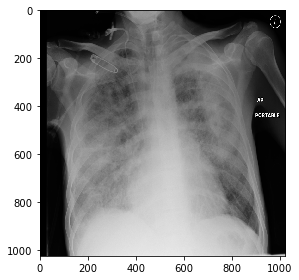

In [92]:
# Plot the image of patient 12834

img2 = io.imread(pn_box['path'][22])
io.imshow(img2)

<function matplotlib.pyplot.show(*args, **kw)>

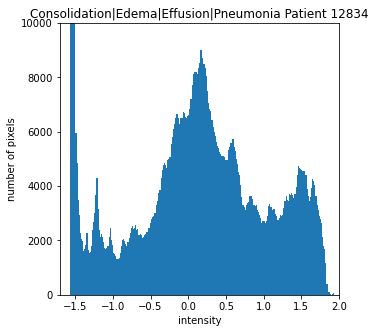

In [93]:
# Plot the histogram of patient 12834

mean2 = np.mean(img2)
std2 = np.std(img2)

# Standardize the plot
pneumonia2 = (img2-mean2)/std2

plt.figure(figsize=(5,5))
plt.hist(pneumonia2.ravel(), bins = 256)
plt.title('Consolidation|Edema|Effusion|Pneumonia Patient 12834')

# We limit the max value of y since on the left there is an 
# extremely high peak caused by the border of the image

plt.axis([-1.7, 2, 0, 10000])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show

In [94]:
# Coordinate the bounding box of patient 12834

lung2_x = [568,835]
lung2_y = [260,684]

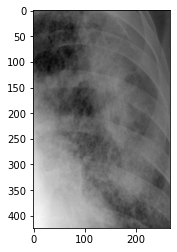

In [95]:
# Image from the bounding box of patient 12834

plt.imshow(pneumonia2[lung2_y[0]:lung2_y[1],lung2_x[0]:lung2_x[1]],cmap='gray')

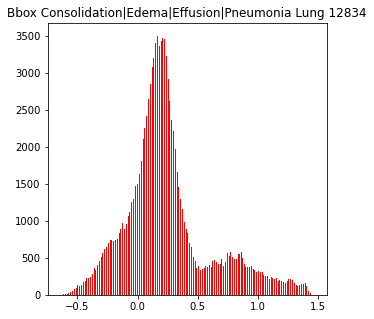

In [96]:
# Plot the histogram from the bounding box of patient 12834

plt.figure(figsize=(5,5))
plt.hist(pneumonia2[lung2_y[0]:lung2_y[1],lung2_x[0]:lung2_x[1]].ravel(), bins = 256,color='red')
plt.title('Bbox Consolidation|Edema|Effusion|Pneumonia Lung 12834')
plt.show()

Now let's look at the histogram of healthy patients.

#### Exploration of No Pneumonia or Normal Images

In [97]:
# Sample 2 rows from nm_box

nm_box.sample(2, random_state=2)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
3268,00016291_002.png,Effusion,2,16291,053Y,M,PA,2992,2991,0.143,0.143,/data/images_008/images/00016291_002.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Effusion,617.244444,676.162378,326.542222,78.506667,NaN,NaN,NaN
2086,00010815_006.png,Mass,6,10815,065Y,M,PA,2842,2991,0.143,0.143,/data/images_005/images/00010815_006.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Atelectasis,311.580451,240.260747,153.600000,244.622222,NaN,NaN,NaN


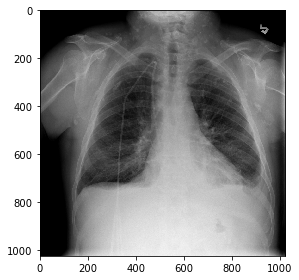

In [98]:
# Plot the image of patient 16291

img3 = io.imread(nm_box['path'][3268])
io.imshow(img3)

<function matplotlib.pyplot.show(*args, **kw)>

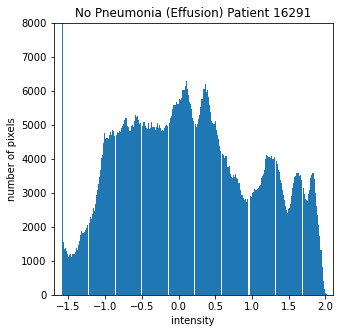

In [99]:
# Plot the histogram of patient 16291

mean3 = np.mean(img3)
std3 = np.std(img3)

# Standardize the plot
normal3 = (img3-mean3)/std3

plt.figure(figsize=(5,5))
plt.hist(normal3.ravel(), bins = 256)
plt.title('No Pneumonia (Effusion) Patient 16291')
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.axis([-1.7, 2.1, 0, 8000])
plt.show

In [100]:
# Coordinate the bounding box of patient 16291

lung3_x = [617, 943]
lung3_y = [676, 754]

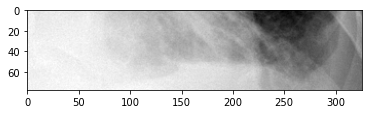

In [101]:
# Image from the bounding box of patient 16291

plt.imshow(normal3[lung3_y[0]:lung3_y[1],lung3_x[0]:lung3_x[1]],cmap='gray')

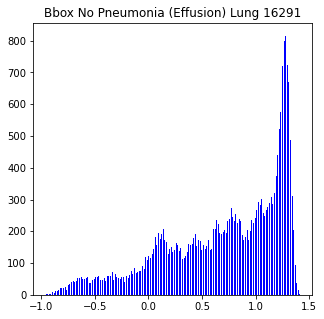

In [102]:
# Plot the histogram from the bounding box of patient 16291

plt.figure(figsize=(5,5))
plt.hist(normal3[lung3_y[0]:lung3_y[1],lung3_x[0]:lung3_x[1]].ravel(), bins = 256,color='blue')
plt.title('Bbox No Pneumonia (Effusion) Lung 16291')
plt.show()

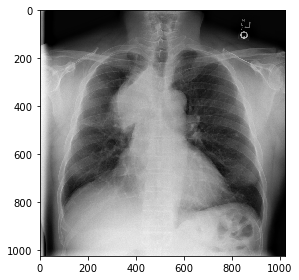

In [103]:
# Plot the image of patient 10815

img4 = io.imread(nm_box['path'][2086])
io.imshow(img4)

<function matplotlib.pyplot.show(*args, **kw)>

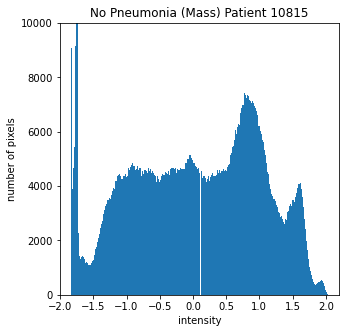

In [104]:
# Plot the histogram of patient 10815

mean4 = np.mean(img4)
std4 = np.std(img4)

# Standardize the plot
normal4 = (img4-mean4)/std4

plt.figure(figsize=(5,5))
plt.hist(normal4.ravel(), bins = 256)
plt.title('No Pneumonia (Mass) Patient 10815')
# We limit the max value of y since on the left there is an 
# extremely high peak caused by the border of the image

plt.axis([-2, 2.2, 0, 10000])
plt.xlabel('intensity')
plt.ylabel('number of pixels')
plt.show

In [105]:
# Coordinate the bounding box of patient 10815

lung4_x = [311,465]
lung4_y = [240,485]

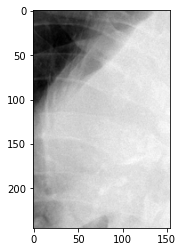

In [106]:
# Image from the bounding box of patient 10815

plt.imshow(normal4[lung4_y[0]:lung4_y[1],lung4_x[0]:lung4_x[1]],cmap='gray')

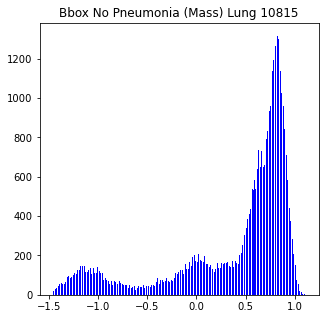

In [107]:
# Plot the histogram from the bounding box of patient 10815

plt.figure(figsize=(5,5))
plt.hist(normal4[lung4_y[0]:lung4_y[1],lung4_x[0]:lung4_x[1]].ravel(), bins = 256,color='blue')
plt.title('Bbox No Pneumonia (Mass) Lung 10815')
plt.show()

Now let's combine the histograms of the bounding box above and analyze.

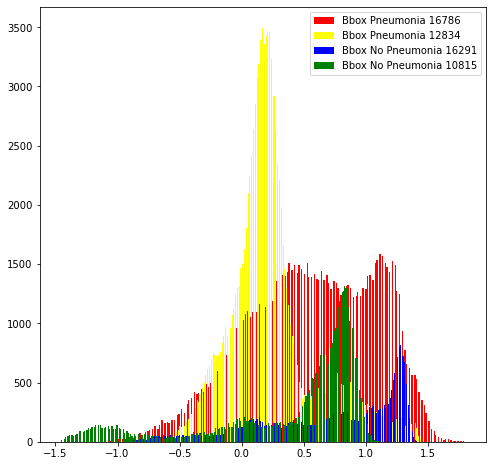

In [108]:
plt.figure(figsize=(8,8))
plt.hist(pneumonia1[lung1_y[0]:lung1_y[1],lung1_x[0]:lung1_x[1]].ravel(), bins = 256,color='red')
plt.hist(pneumonia2[lung2_y[0]:lung2_y[1],lung2_x[0]:lung2_x[1]].ravel(), bins = 256,color='yellow')
plt.hist(normal3[lung3_y[0]:lung3_y[1],lung3_x[0]:lung3_x[1]].ravel(), bins = 256,color='blue')
plt.hist(normal4[lung4_y[0]:lung4_y[1],lung4_x[0]:lung4_x[1]].ravel(), bins = 256,color='green')
plt.legend(['Bbox Pneumonia 16786','Bbox Pneumonia 12834','Bbox No Pneumonia 16291','Bbox No Pneumonia 10815'])
plt.show()

The intensity values of the lungs of the patients with pneumonia and the ones with no pneumonia are almost similar. Most have values that are higher than the image mean, and mostly fall within one or two standard deviation.

Similarly, the intensity values of the bounding boxes of the patients with pneumonia and the ones with no pneumonia also have values that are higher than the image mean which mostly also fall within one or two standard deviation (with the exception Patient 16291 which has Effusion, the intensity values are higher than the image mean at about three standard deviation).  

## Summary

From the exploratory data analysis of Data_Entry_2017.csv, we see that our model will train on population of males and females between ages of 1 to 95. However, most of the patients will be around their 50s as the number of patients decreases as the age increases and decreases from about age 50s. Also, we see that there are a little more males than females in the overal population and also in the ones with pneumonia. The model will train on images which are obtained from digital Chest-X-Ray with view position either AP or PA. 

The population which has pneumonia, possibly will also have other diseases such as infiltraion, edema and infiltration, and atelectasis as these diseases are among the top commorbities which frequently occur with pneumonia. However, after exploring the intensity values of each 14 desease labels, we see that infiltration, edema, and pneumonia almost have similar distribution. All of them have the highest peak around the image mean. This means that there is a porbability that our algorithm will performs very poorly on the accurate detection of pneumonia in the presence of infiltration and edema.  

From the exploratory analysis of sample_labels.csv and BBox_List_2017.csv, we see that there is no difference in intensity values of all images with pneumonia and no pneumonia as both have intensity values higher than the image mean at about one or two standard deviations. Similartly, intensity values of individual lungs and bounding boxes of patients with pneumonia and the ones with no pneumonia also follow the same patern. This means that using some sort of intensity value thresholding mechanism to identify pneumonia in an image for our model would probably not be appropriate, because the pneumonia's intensity values are not that different from the rest of the image.